In [1838]:
using RobustAndOptimalControl
using ControlSystemsBase 
using Plots

In [1839]:
function parse_tf_from_file(fname)

    file = open(fname, "r")
    lines = readlines(file)
    close(file)

    # join to one String
    lines = join(lines)
    num = split(lines, "]")[1]
    num = replace(num, "[" => "")

    den = split(lines, "]")[2]
    den = replace(den, "[" => "")
    den = replace(den, "]" => "")


    num_f = []
    for fs in split(num, " ")
        if fs == ""
            continue
        end
        push!(num_f, parse(Float64, fs))
    end

    den_f = []
    for fs in split(den, " ")
        if fs == ""
            continue
        end
        push!(den_f, parse(Float64, fs))
    end

    num_f = Vector{Float64}(num_f)
    den_f = Vector{Float64}(den_f)


    G = tf(num_f, den_f)
    G = minreal(G)
    return G
end

parse_tf_from_file (generic function with 1 method)

# Plant

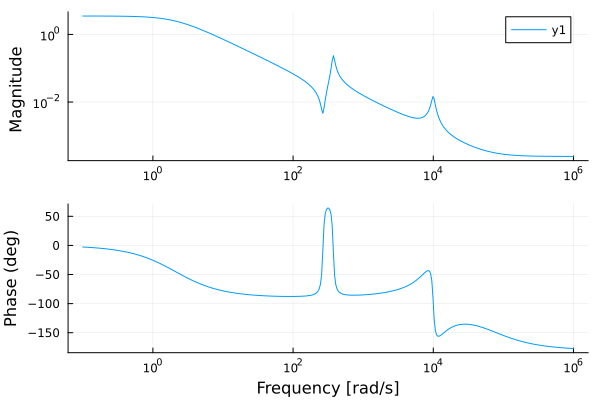

In [ ]:
s = tf("s")
G = parse_tf_from_file("Gf.txt")

bodeplot(G)

In [1841]:
function pt2(w0,d)
    s = tf("s")
    return w0^2/(s^2 + 2*d*w0*s + w0^2)
end

pt2 (generic function with 1 method)

# Uncertainty

TransferFunction{Continuous, ControlSystemsBase.SisoRational{Float64}}
3.136e6s^3 + 8.985259334580639e9s^2 + 6.375554454730315e12s + 4.2907844383112206e14
-----------------------------------------------------------------------------------
78400.0s^3 + 1.3691129136451607e10s^2 + 1.53856957368258e12s + 1.072696109577806e15

Continuous-time transfer function model

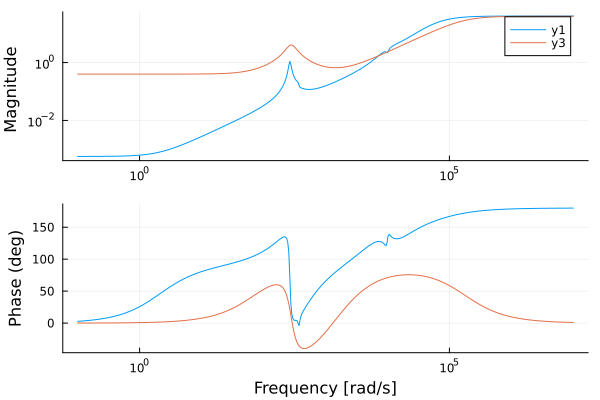

In [1842]:

W1 = 0.1
W2 = pt2(250,0.1)/pt2(250,0.8)
W3 = (s/3000 + 1)^2/(s/(5*1e5) + 1)^2
W_delta = W1*W2*W3


ROB_SCALE = 1 # Increase for more robustness
W_delta = makeweight(0.4, 4000, 40) |> tf
#W_delta = W_delta* pt2(260,0.05)/(pt2(260,1.1)) * ROB_SCALE
W_delta = W_delta* pt2(280,0.2)/(pt2(280,2)) * ROB_SCALE
W_delta0 = parse_tf_from_file("W_delta.txt")

print(W_delta)

bodeplot([W_delta0,W_delta])



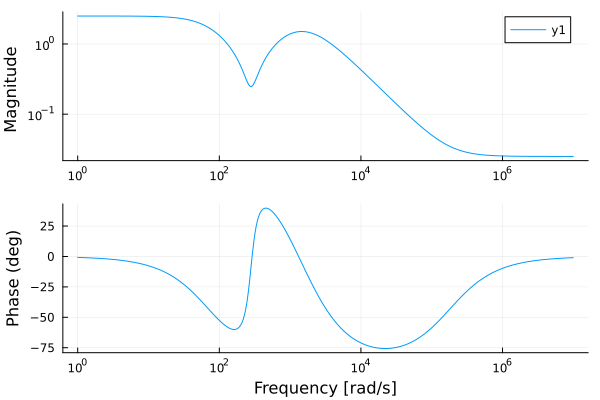

In [1843]:
bodeplot(1/W_delta)

# Control limit

50265.48245743669

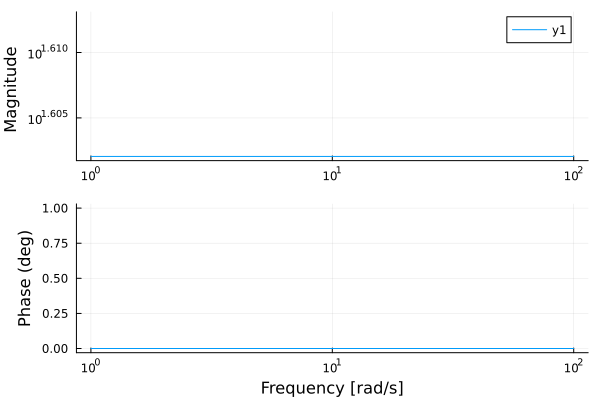

In [ ]:


# Max Torque, and Nyquist freq as dynamic limit
#w_nyq = 2*pi/(125*1e-6)
#print(w_nyq)
#max_T = 40

WU = ss(1)*max_T

bodeplot(WU)

In [1845]:
WU = 1/WU

StateSpace{Continuous, Float64}
D = 
 0.025

Continuous-time state-space model

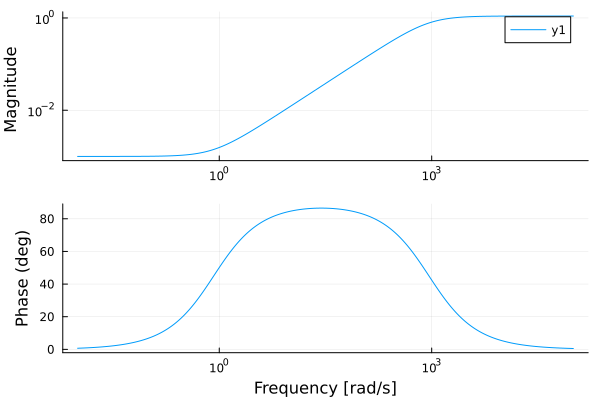

In [1846]:
# Desired closed loop bw rad/s
omega_cl = 2000

WS = 1/makeweight(1e-3, omega_cl, 1.1) |> tf

bodeplot([1/WS])


In [1847]:

WT = W_delta

P = hinfpartition(G, WS, WU, WT)
hinfassumptions(P)



All assumtions are satisfied!


true

3.0608802355148637

┌ Warning: Numerical problems encountered, returned γ is adjusted to the γ achieved by the computed controller (γ - γactual = 0.011956628845543271). Try solving the problem in higher precision by calling hinfsynthesize(...; ftype=BigFloat)
└ @ RobustAndOptimalControl C:\Users\Elias\.julia\packages\RobustAndOptimalControl\Qj5nj\src\hinfinity_design.jl:203


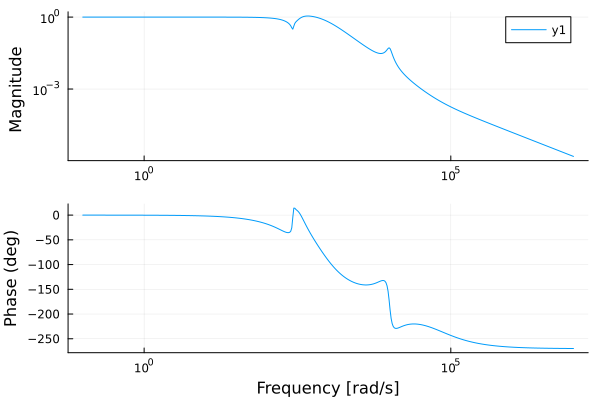

In [1848]:
K, y = hinfsynthesize(P, γrel=1.05)

K = minreal(K)

print(y)

Pcl, S, KS, T = hinfsignals(P, G, K)

Pcl = G*K/(1 + G*K)

Pcl = minreal(Pcl)

bodeplot(Pcl)

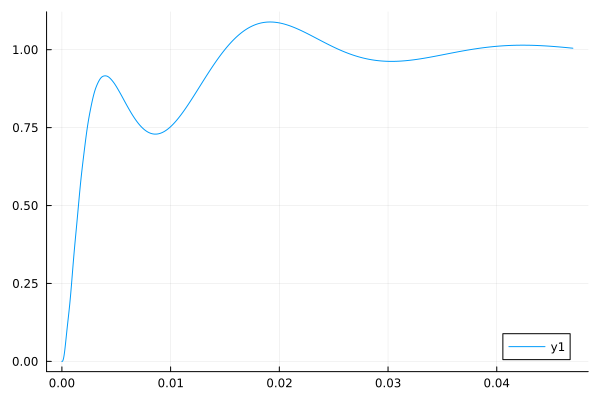

In [1849]:
y, t = step(Pcl);
plot(t, y')

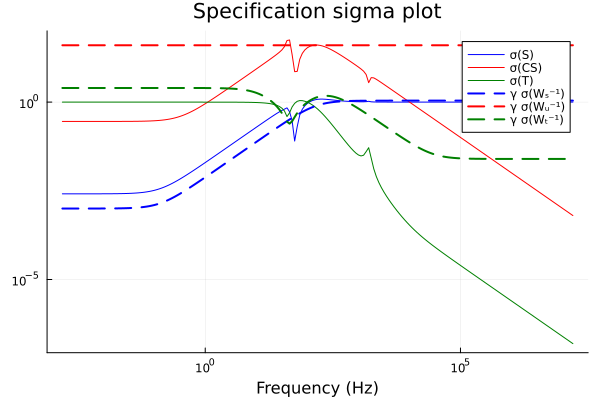

In [1850]:
specificationplot([S,K*S,T], [WS,WU,WT],wint=(-2,8))

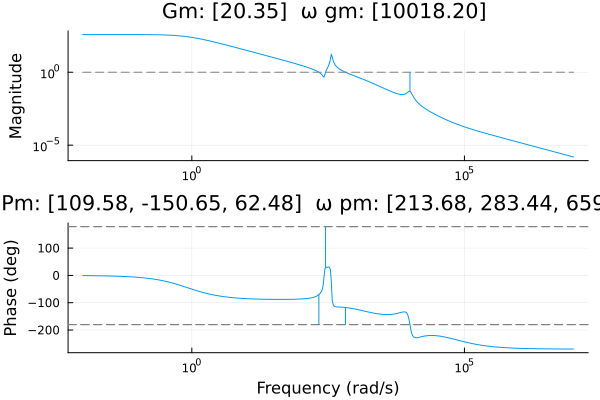

In [1852]:
L = minreal(G*K)
marginplot(L)

In [1853]:
K = tf(K)

num = K.matrix[1,1].num.coeffs
den = K.matrix[1,1].den.coeffs

fpath = "K_hinf.txt"
open(fpath, "w") do file
    write(file, string(num))
    write(file, "\n")
    write(file, string(den))
end

K

TransferFunction{Continuous, ControlSystemsBase.SisoRational{Float64}}
   63435.35006119555s^8 + 1.1143346171407019e10s^7 + 1.9041265820570863e13s^6 + 1.1120675634976776e18s^5 + 1.6444658593218016e20s^4 + 2.461935588123151e23s^3 + 2.0715329115078836e25s^2 + 1.2179284079481034e28s + 2.54578589307256e28
-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
1.0s^9 + 179083.22248769348s^8 + 7.129899817324027e8s^7 + 1.8420796047054184e13s^6 + 2.8699747096276404e16s^5 + 5.629647219868107e18s^4 + 5.90204608357346e21s^3 + 3.971796044633521e23s^2 + 2.7860583313204097e26s + 2.3186094792583734e26

Continuous-time transfer function model